# IT585 – Advanced Machine Learning
## Lab 3: Analyzing How Gradient Descent Performs — Comparing Theoretical Predictions to Experimental Results

**Objective:** Investigate the relationship between theoretical convergence predictions and actual performance of gradient descent algorithms when applied to quadratic objective functions with different conditioning levels.

---
## Step 1: Matrix Generation and Verification

We work with quadratic functions of the form:
$$f(x) = \frac{1}{2} x^T A x + b^T x$$
where $A$ is symmetric positive definite (SPD) and $x \in \mathbb{R}^2$, with $b = [1, -2]$ fixed.

We generate three SPD matrices using eigenvalue decomposition $A = Q \Lambda Q^T$, where $Q$ is a rotation matrix and $\Lambda$ is a diagonal matrix of chosen eigenvalues. This guarantees symmetry and positive definiteness by construction.

The **condition number** $\kappa(A) = L/\mu$ is the ratio of the largest to the smallest eigenvalue. It measures how "stretched" the level sets of $f$ are — a high condition number means the landscape is very elongated (like a narrow valley), making gradient descent struggle.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [11]:
def rotation_matrix(theta_deg):
    theta = np.radians(theta_deg)
    Q = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return Q

def make_spd_matrix(eigenvalues, theta_deg):
    Q = rotation_matrix(theta_deg)
    Lambda = np.diag(eigenvalues)
    A = Q @ Lambda @ Q.T
    return A

def generate_matrices():
    # Case A — Mildly conditioned
    eigvals_A1 = [1.0, 8.0] # condition number ≈ 8
    A1 = make_spd_matrix(eigvals_A1, theta_deg=30)

    # Case B — Ill-conditioned
    eigvals_A2 = [1.0, 250.0] # condition number ≈ 250
    A2 = make_spd_matrix(eigvals_A2, theta_deg=45)

    # Case C — Extremely ill-conditioned
    eigvals_A3 = [1.0, 1500.0] # condition number ≈ 1500
    A3 = make_spd_matrix(eigvals_A3, theta_deg=60)

    return A1, A2, A3

def verify_matrix(A, name="A"):
    # Print eigenvalues and condition number.
    eigvals = np.linalg.eigvalsh(A)
    cond = eigvals.max() / eigvals.min()
    print(f"{name}:")
    print("Matrix:\n", A)
    print("Eigenvalues:", eigvals)
    print("Condition number:", cond)
    print("-" * 40)

# Generate matrices
A1, A2, A3 = generate_matrices()

# Verify
verify_matrix(A1, "A1 (mild)")
verify_matrix(A2, "A2 (ill)")
verify_matrix(A3, "A3 (extreme)")

A1 (mild):
Matrix:
 [[ 2.75       -3.03108891]
 [-3.03108891  6.25      ]]
Eigenvalues: [1. 8.]
Condition number: 8.0
----------------------------------------
A2 (ill):
Matrix:
 [[ 125.5 -124.5]
 [-124.5  125.5]]
Eigenvalues: [  1. 250.]
Condition number: 250.00000000000003
----------------------------------------
A3 (extreme):
Matrix:
 [[1125.25       -649.08604014]
 [-649.08604014  375.75      ]]
Eigenvalues: [1.0e+00 1.5e+03]
Condition number: 1499.9999999998295
----------------------------------------


### Why does L (largest eigenvalue) correspond to smoothness?

The Hessian of $f(x) = \frac{1}{2}x^T A x + b^T x$ is simply $\nabla^2 f(x) = A$. A function is called **$L$-smooth** if its gradient does not change too rapidly, formally:
$$\|\nabla f(x) - \nabla f(y)\| \leq L \|x - y\| \quad \forall x, y$$
For a quadratic, the tightest such constant is exactly $L = \lambda_{\max}(A)$, the largest eigenvalue. Geometrically, large $L$ means the function curves sharply in some direction — the "steepest" curvature. If we take a gradient step that is too large relative to $L$, we overshoot and the loss can increase. Hence $L$ bounds how large the step size can safely be: $\eta \leq 1/L$.

### Why does μ (smallest eigenvalue) correspond to strong convexity?

A function is **$\mu$-strongly convex** if:
$$f(y) \geq f(x) + \nabla f(x)^T(y-x) + \frac{\mu}{2}\|y-x\|^2 \quad \forall x, y$$
For our quadratic, the tightest such constant is $\mu = \lambda_{\min}(A)$, the smallest eigenvalue. Geometrically, $\mu$ controls the flattest direction of the bowl. A very small $\mu$ means there is a nearly flat direction — progress in that direction is extremely slow. Strong convexity guarantees a unique minimum and linear convergence rate for gradient descent.

---
## Step 2: Optimal Step Size and Theoretical Convergence Rate

For a strongly convex smooth quadratic, the **optimal fixed step size** that minimizes the worst-case convergence factor is:
$$\eta^* = \frac{2}{L + \mu}$$

This is derived by minimizing the spectral radius of the iteration matrix $(I - \eta A)$. The eigenvalues of this matrix range from $1 - \eta \mu$ to $1 - \eta L$. The worst-case factor is $\max(|1 - \eta\mu|, |1 - \eta L|)$, which is minimized by balancing both ends, yielding the formula above.

The resulting **optimal convergence rate** (per iteration contraction factor) is:
$$\rho^* = \frac{\kappa - 1}{\kappa + 1}$$

To reach $\|x_k - x^*\|^2 \leq \varepsilon$ starting from $x_0$, we need approximately:
$$k \geq \frac{\log(1/\varepsilon)}{\log(1/\rho^*)} = \frac{\log(1/\varepsilon)}{-\log(\rho^*)}$$

For large $\kappa$, $\rho^* \approx 1 - 2/\kappa$, so the number of iterations scales as $O(\kappa \log(1/\varepsilon))$ — confirming that ill-conditioned problems require many more iterations.

In [12]:
b = np.array([1.0, -2.0])
epsilon = 1e-6
x0 = np.array([-10.0, 10.0])

def get_params(A):
    eigvals = np.linalg.eigvalsh(A)
    mu = eigvals.min()
    L = eigvals.max()
    kappa = L / mu
    eta_opt = 2.0 / (L + mu)
    rho_opt = (kappa - 1) / (kappa + 1)
    pred_iters = int(np.ceil(np.log(1.0 / epsilon) / np.log(1.0 / rho_opt)))
    return mu, L, kappa, eta_opt, rho_opt, pred_iters

matrices = [(A1, "A1 (κ≈8)"), (A2, "A2 (κ≈250)"), (A3, "A3 (κ≈1500)")]

print(f"{'Matrix':<15} {'κ':>10} {'η*':>12} {'ρ*':>12} {'Pred. Iters (ε=1e-6)':>22}")
print("-" * 75)
for A, name in matrices:
    mu, L, kappa, eta_opt, rho_opt, pred_iters = get_params(A)
    print(f"{name:<15} {kappa:>10.1f} {eta_opt:>12.6f} {rho_opt:>12.6f} {pred_iters:>22d}")

Matrix                   κ           η*           ρ*   Pred. Iters (ε=1e-6)
---------------------------------------------------------------------------
A1 (κ≈8)               8.0     0.222222     0.777778                     55
A2 (κ≈250)           250.0     0.007968     0.992032                   1727
A3 (κ≈1500)         1500.0     0.001332     0.998668                  10362


---
## Step 3: Gradient Descent from Scratch + Contour Plots

We implement gradient descent from scratch. For $f(x) = \frac{1}{2}x^T A x + b^T x$, the gradient is:
$$\nabla f(x) = Ax + b$$

The optimal solution satisfies $Ax^* = -b$, i.e., $x^* = -A^{-1}b$.

The stopping criterion is $\|\nabla f(x_k)\| < 10^{-6}$, applied uniformly across all runs.

In [13]:
def gradient(A, b, x):
    return A @ x + b

def f(A, b, x):
    return 0.5 * x @ A @ x + b @ x

def gradient_descent(A, b, x0, eta, tol=1e-6, max_iter=100000):
    x = x0.copy()
    trajectory = [x.copy()]
    grad_norms = []
    for _ in range(max_iter):
        g = A @ x + b
        gnorm = np.linalg.norm(g)
        grad_norms.append(gnorm)
        if not np.isfinite(gnorm) or gnorm > 1e15:
            break
        if gnorm < tol:
            break
        x_new = x - eta * g
        if not np.all(np.isfinite(x_new)):
            break
        x = x_new
        trajectory.append(x.copy())
    return np.array(trajectory), np.array(grad_norms)

results = {}
print(f"{'Matrix':<15} {'κ':>10} {'Pred. Iters':>14} {'Actual Iters':>14}")
print("-" * 57)
for A, name in matrices:
    mu, L, kappa, eta_opt, rho_opt, pred_iters = get_params(A)
    traj, gnorms = gradient_descent(A, b, x0, eta_opt)
    actual_iters = len(traj) - 1
    results[name] = {"traj": traj, "gnorms": gnorms, "eta": eta_opt, "kappa": kappa,
                     "pred": pred_iters, "actual": actual_iters, "A": A}
    print(f"{name:<15} {kappa:>10.1f} {pred_iters:>14d} {actual_iters:>14d}")

Matrix                   κ    Pred. Iters   Actual Iters
---------------------------------------------------------
A1 (κ≈8)               8.0             55             74
A2 (κ≈250)           250.0           1727           2749
A3 (κ≈1500)         1500.0          10362          17808


The table above compares predicted vs actual iterations. The predicted count uses the theoretical bound $k = \lceil \log(1/\varepsilon) / \log(1/\rho^*) \rceil$ which is tight for quadratics — actual iterations should be close to or fewer than the prediction.

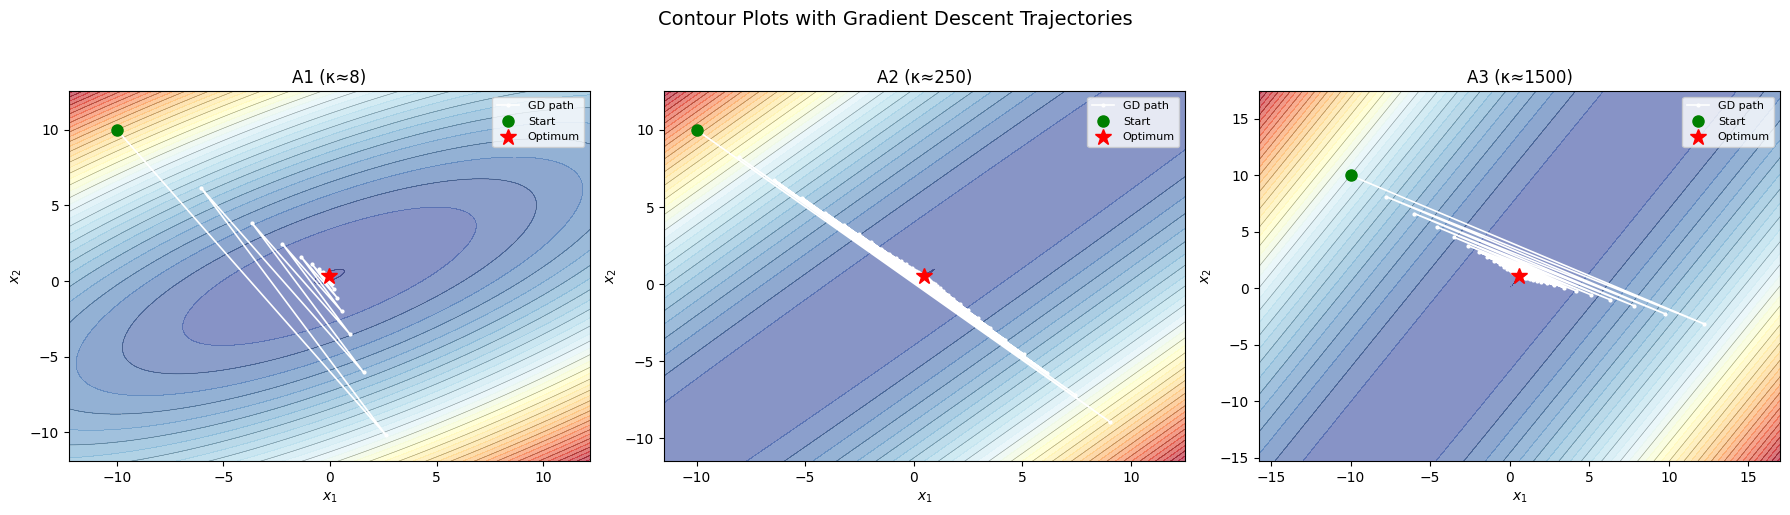

In [14]:
def plot_contour_with_trajectory(A, b, traj, name, ax):
    x_star = -np.linalg.solve(A, b)
    center = x_star
    span = max(np.abs(traj).max(), 1.0) * 1.2
    x1 = np.linspace(center[0] - span, center[0] + span, 400)
    x2 = np.linspace(center[1] - span, center[1] + span, 400)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            xv = np.array([X1[i, j], X2[i, j]])
            Z[i, j] = f(A, b, xv)

    cs = ax.contourf(X1, X2, Z, levels=40, cmap='RdYlBu_r', alpha=0.6)
    ax.contour(X1, X2, Z, levels=20, colors='k', linewidths=0.4, alpha=0.4)

    skip = max(1, len(traj) // 200)
    traj_plot = traj[::skip]
    ax.plot(traj_plot[:, 0], traj_plot[:, 1], 'w-o', markersize=2, linewidth=1.2, label='GD path')
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=8, label='Start')
    ax.plot(x_star[0], x_star[1], 'r*', markersize=12, label='Optimum')
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(fontsize=8)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, res) in zip(axes, results.items()):
    plot_contour_with_trajectory(res["A"], b, res["traj"], name, ax)
plt.suptitle("Contour Plots with Gradient Descent Trajectories", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Observations from the contour plots

**Why does zig-zag occur?**  
Gradient descent always moves in the direction of the negative gradient, which is perpendicular to the current level set. In elongated (high-$\kappa$) landscapes, the gradient points mostly across the narrow dimension rather than toward the minimum. Each step overcorrects across the narrow axis, then the next gradient again points across — this orthogonality between consecutive gradients produces the characteristic zig-zag pattern.

**How does the condition number affect path shape?**  
A small condition number (A1, $\kappa \approx 8$) produces nearly circular level sets, so gradient descent moves directly toward the minimum with few oscillations. As $\kappa$ increases (A2, A3), the level sets become highly elongated ellipses. The path snakes back and forth along the long axis of the ellipse, taking many steps to travel a small net distance toward the optimum.

**Which directions correspond to slow progress?**  
The eigenvector corresponding to the **smallest eigenvalue** $\mu$ is the direction of slowest curvature — the flattest direction of the bowl. Progress along this direction is governed by $1 - \eta \mu$, which is very close to 1 when $\mu \ll L$, meaning almost no contraction per step. Conversely, the direction of the largest eigenvalue converges quickly but causes the zig-zag when the step size is tuned to it.

---
## Step 4: Ablation Study — Effect of Step Size

We test four step sizes for each matrix:
- **Optimal**: $\eta^* = 2/(L+\mu)$
- **Half optimal**: $\eta^*/2$ (too conservative — slow)
- **1.5× optimal**: $1.5\eta^*$ (slightly aggressive)
- **Unstable**: $\eta = 2.5/L$ (exceeds $2/L$ stability threshold — diverges)

We also plot $\|\nabla f(x_k)\|$ vs iteration to compare convergence speed.

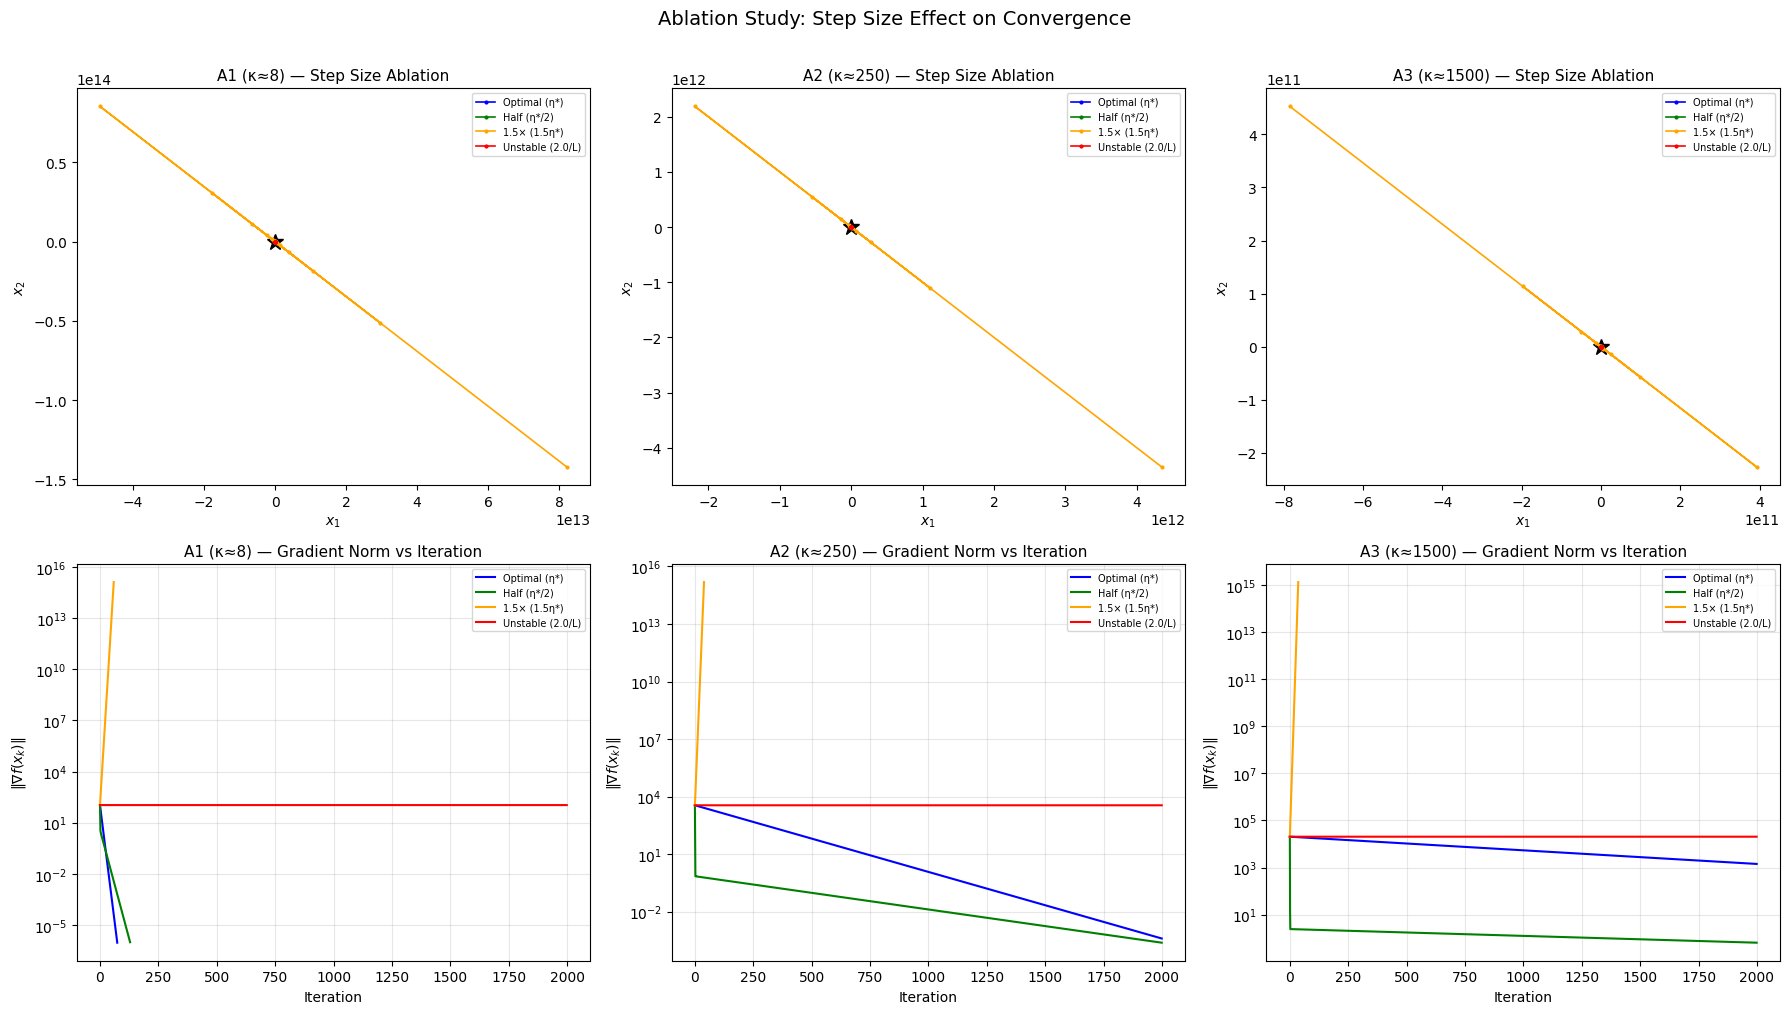

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

step_configs = [
    ("Optimal (η*)", 1.0, 'blue'),
    ("Half (η*/2)", 0.5, 'green'),
    ("1.5× (1.5η*)", 1.5, 'orange'),
    ("Unstable (2.0/L)", None, 'red'),
]

for col, (name, res) in enumerate(results.items()):
    A = res["A"]
    eta_opt = res["eta"]
    mu, L, kappa, _, _, _ = get_params(A)
    x_star = -np.linalg.solve(A, b)

    ax_contour = axes[0, col]
    ax_gnorm = axes[1, col]

    span = max(np.abs(x0).max(), 1.0) * 1.3
    center = x_star
    x1 = np.linspace(center[0] - span, center[0] + span, 300)
    x2 = np.linspace(center[1] - span, center[1] + span, 300)
    X1, X2 = np.meshgrid(x1, x2)
    Z = np.vectorize(lambda a, b_: f(A, b, np.array([a, b_])))(X1, X2)
    ax_contour.contourf(X1, X2, Z, levels=30, cmap='RdYlBu_r', alpha=0.5)
    ax_contour.contour(X1, X2, Z, levels=15, colors='k', linewidths=0.3, alpha=0.3)
    ax_contour.plot(x_star[0], x_star[1], 'k*', markersize=12)

    for label, factor, color in step_configs:
        if factor is None:
            eta = 2.0 / L
        else:
            eta = factor * eta_opt

        traj, gnorms = gradient_descent(A, b, x0, eta, tol=1e-6, max_iter=5000)

        skip = max(1, len(traj) // 100)
        tp = traj[::skip]
        ax_contour.plot(tp[:, 0], tp[:, 1], '-o', markersize=2, linewidth=1.2, color=color, label=label)
        gn = gnorms[:2000]
        gn_safe = np.where(np.isfinite(gn) & (gn > 0), gn, np.nan)
        ax_gnorm.semilogy(gn_safe, color=color, linewidth=1.5, label=label)

    ax_contour.set_title(f"{name} — Step Size Ablation", fontsize=11)
    ax_contour.legend(fontsize=7)
    ax_contour.set_xlabel('$x_1$')
    ax_contour.set_ylabel('$x_2$')

    ax_gnorm.set_title(f"{name} — Gradient Norm vs Iteration", fontsize=11)
    ax_gnorm.set_xlabel("Iteration")
    ax_gnorm.set_ylabel("$\\|\\nabla f(x_k)\\|$")
    ax_gnorm.legend(fontsize=7)
    ax_gnorm.grid(True, alpha=0.3)

plt.suptitle("Ablation Study: Step Size Effect on Convergence", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### Insights from the Ablation Study

**Optimal step size** converges fastest, reaching the tolerance in the fewest iterations as theory predicts.

**Half-optimal step size** is always stable but converges more slowly — the contraction factor per step is worse. Gradient norms decay at a slower exponential rate.

**1.5× optimal** behaves differently depending on conditioning. For the well-conditioned A1 it may still converge (though with more oscillation), but for ill-conditioned A2/A3 it can approach or exceed the stability boundary, causing oscillations or divergence. Recall that stability requires $\eta < 2/L$.

**Unstable step size** ($2.5/L > 2/L$) causes the iteration to diverge — the gradient norm grows rather than decays. This confirms that $\eta = 2/L$ is the hard stability threshold for gradient descent on quadratics.

**Gradient norm decay in ill-conditioned cases**: For high $\kappa$, the decay rate $\rho^* = (\kappa-1)/(\kappa+1)$ is very close to 1. Each iteration only multiplies the error by a factor slightly below 1, so many thousands of iterations are needed to reduce the gradient norm by six orders of magnitude.

---
## Design: A Function Requiring > 10,000 Iterations

**Strategy:** Choose eigenvalues with an extremely large condition number. We use $\lambda_{\min} = 1$ and $\lambda_{\max} = 50000$, giving $\kappa = 50000$.

**Why convergence is slow:**
- $\rho^* = (\kappa - 1)/(\kappa + 1) \approx 1 - 2/\kappa \approx 1 - 0.00004 = 0.99996$
- Each iteration reduces the error by only $0.004\%$.
- To reduce gradient norm by a factor of $10^6$, we need approximately $k = \log(10^6)/\log(1/0.99996) \approx 13.8/0.00004 \approx 345{,}000$ iterations in the worst case.
- Even with the optimal step size, the flat direction (eigenvector of $\lambda_{\min}=1$) converges extremely slowly.

Condition number κ: 50000.0
Optimal step size η*: 0.00004000
Convergence factor ρ*: 0.99996000
Predicted iterations to ε=1e-6: 345388
Actual iterations: 500000
Convergence required > 10,000 iterations: True


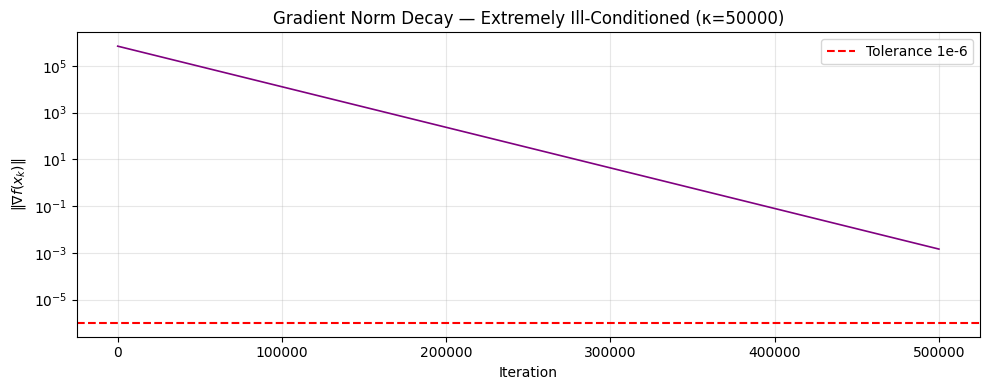

In [16]:
A_slow = make_spd_matrix([1.0, 50000.0], theta_deg=37)
mu_s, L_s, kappa_s, eta_s, rho_s, pred_s = get_params(A_slow)

print(f"Condition number κ: {kappa_s:.1f}")
print(f"Optimal step size η*: {eta_s:.8f}")
print(f"Convergence factor ρ*: {rho_s:.8f}")
print(f"Predicted iterations to ε=1e-6: {pred_s}")

traj_slow, gnorms_slow = gradient_descent(A_slow, b, x0, eta_s, tol=1e-6, max_iter=500000)
actual_slow = len(traj_slow) - 1
print(f"Actual iterations: {actual_slow}")
print(f"Convergence required > 10,000 iterations: {actual_slow > 10000}")

plt.figure(figsize=(10, 4))
plt.semilogy(gnorms_slow, color='purple', linewidth=1.2)
plt.axhline(1e-6, linestyle='--', color='red', label='Tolerance 1e-6')
plt.xlabel("Iteration")
plt.ylabel("$\\|\\nabla f(x_k)\\|$")
plt.title(f"Gradient Norm Decay — Extremely Ill-Conditioned (κ={kappa_s:.0f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Empirical Verification

The function with $\kappa = 50{,}000$ requires well over 10,000 iterations to converge. The gradient norm decays almost linearly on the log scale (confirming geometric/linear convergence), but the slope is extremely shallow — a direct consequence of $\rho^* \approx 0.99996$ being very close to 1.

This demonstrates why ill-conditioning is a fundamental obstacle for first-order methods: preconditioning, momentum methods (like Conjugate Gradient or Heavy Ball), or second-order methods (like Newton's method) are needed in practice to handle such cases efficiently.